In [1]:
using Pkg
Pkg.activate("/Users/mathieu/Documents/AdaptiveTransportMap/")

 Activating environment at `~/Documents/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test

In [3]:
path = "/Users/mathieu/Documents/AdaptiveTransportMap/src/lorenz63/data/"
Nx = 3
Ny = 3
Ne = 100
β = sqrt(1.02)
@time model, data = setup_lorenz63(path, [Ne]);

 90.778102 seconds (141.15 M allocations: 8.167 GiB, 3.15% gc time)


In [5]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [6]:
state, Ne, x0, tt, xt, yt = load(path*"set_up_Ne"*string(Ne)*".jld", "state", "Ne", "x0", "tt", "xt", "yt");

In [7]:
state[1000]

3×100 Array{Float64,2}:
 10.3187  10.1223  10.1757  10.0892  …  10.4049  10.1594  10.3618  10.1041
 16.413   16.1726  16.2228  16.1921     16.4835  16.2043  16.4139  16.1791
 19.8835  19.5086  19.6893  19.3538     20.1184  19.6673  20.0764  19.448

In [8]:
xt[:,1000]

3-element Array{Float64,1}:
  8.446097720088602
  7.65485619028356
 27.58155215449147

In [9]:
x̄ = hcat(map(x-> mean(x; dims = 2)[:,1], state)...)

3×2001 Array{Float64,2}:
 0.0549273  0.945275   1.89265   3.90646  …   7.50059   7.95204   8.55458
 0.219265   1.76557    4.00657   8.37194      8.17903   9.0034    9.76663
 0.0909552  0.0932404  0.458174  1.49649     24.8166   24.837    25.4004

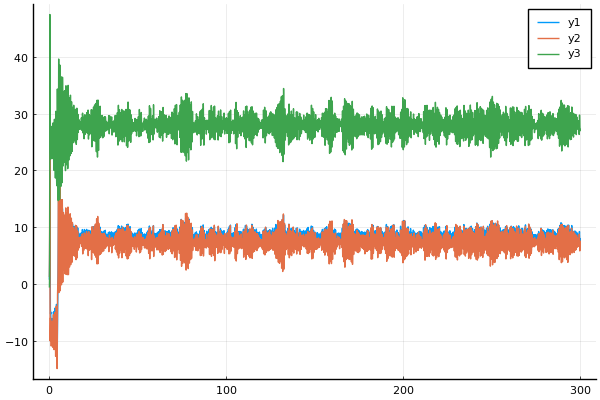

In [10]:
plt = plot()
for i=1:Nx
    plot!(plt, tt, xt[i,:])
end
plt

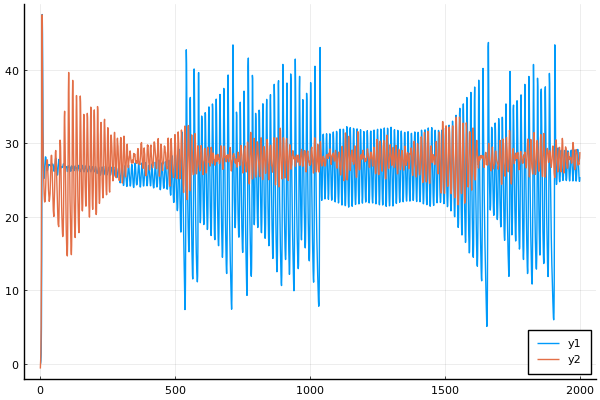

In [11]:
plot(x̄[3,:])
plot!(xt[3,1:2001])

In [12]:
xt[:,1500]

3-element Array{Float64,1}:
  7.796438327102925
  9.015374898765828
 24.03698933228293

In [13]:
x̄[:,1501]

3-element Array{Float64,1}:
 10.953310707665132
 12.438446462392621
 28.332683391135934

In [14]:
norm(x̄[:, 1501:2001] - xt[:,1500:2000])/sqrt(Nx)

188.64255290937015